In [279]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from bs4 import BeautifulSoup
from urllib2 import urlopen
import sqlite3
from functools import partial
from collections import defaultdict
import re 

%matplotlib inline

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


(0, 5.0)

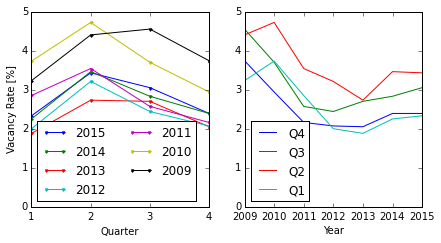

In [406]:
data = pd.read_table('MGE_multifam_vacancy.txt', delimiter='    ', )
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
ax = axes[0]
data_iter = data.iteritems()
data_iter.next()
for year, rates in data_iter:
    ax.plot(range(4, 0, -1), rates, '.-', label=year)
    
ax.set_xlabel('Quarter')
ax.set_ylabel('Vacancy Rate [%]')
ax.get_xaxis().set_ticks(range(1, 5))
ax.legend(loc='best', ncol=2)
ax.set_ylim(0)
ax = axes[1]
years = [datetime.datetime(int(yr), 1, 1) for yr in data.columns[1:].values]

for row, row_data in data.iterrows():
    ax.plot(years, row_data.values[1:], label="Q%1.0f"%row_data.values[0])
    
ax.set_xlabel("Year")
ax.legend(loc='best')
ax.set_ylim(0)


(0, 5.0)

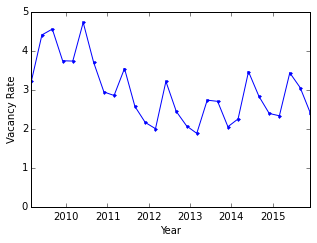

In [176]:
date = [datetime.datetime(int(yr), int(month*3), 1) for yr in data.columns[1:].values for month in data['Quarter']]
vac_rate = data.values[:, 1:].ravel(order='F')
fig, axis = plt.subplots(1, figsize=(5, 3.5))
axis.plot(date, vac_rate, '.-')
axis.set_xlabel('Year')
axis.set_ylabel('Vacancy Rate')

axis.set_ylim(0)

In [368]:
conn = sqlite3.connect('/Users/spardy/MGE_Vacancy.db')
c = conn.cursor()
for year in xrange(2003, 2016, 1):
    for quarter in xrange(1, 5):
        table_name = "rv_{:d}Qtr{:d}".format(year, quarter)
        c.execute("DROP TABLE if exists %s" % table_name)
        c.execute("CREATE TABLE %s (Town, ZIP, Units, Vacant, Percent)" % table_name)              
        if year == 2015 and quarter == 4:
            url = 'https://www.mge.com/customer-service/multifamily/vacancy-rates/'
        else:
            url = 'https://www.mge.com/customer-service/multifamily/vacancy-rates/rv_{:d}Qtr{:d}.htm'.format(year,
                                                                                                             quarter)
        page = urlopen(url)
        soup = BeautifulSoup(page.read(), 'html.parser')
        for row in soup.find_all("td", attrs={'class': re.compile(r".*\bhighlight\b.*")}):
            column_data = ['']*5
            for i, column in enumerate(row.parent.find_all("td")):
                if i > 4:
                    break
                column_data[i] = column.text
            else:  # no break 
                c.execute("INSERT INTO %s VALUES (?, ?, ?, ?, ?)" % table_name, (column_data))

conn.commit()
conn.close()

In [369]:
conn = sqlite3.connect('/Users/spardy/MGE_Vacancy.db')
c = conn.cursor()
vacancy_data = {}
for year in xrange(2003, 2016, 1):
    vacancy_data[year] = {}
    for quarter in xrange(1, 5):
        table_name = "rv_{:d}Qtr{:d}".format(year, quarter)
        data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
        if data[0][0] > 0:
            data = c.execute("SELECT * FROM %s" % table_name).fetchall()
        else:
            continue
            
        #Trim data
        data[:] = [x for x in data[:] if x[1].isdigit()]
            
        vacancy_data[year][quarter] = data
        
conn.close()     

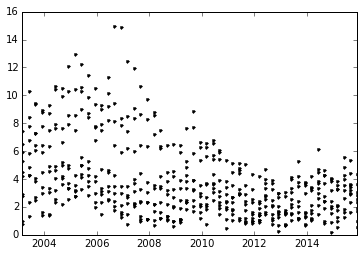

In [371]:
for year, yearly_data in vacancy_data.iteritems():
    for quarter, quarterly_data in yearly_data.iteritems():
        date = datetime.datetime(int(year), int(quarter*3), 1)
        for zip_data in quarterly_data:
            if zip_data[0] == 'Madison':
                plt.plot(date, zip_data[4], 'k.')

In [372]:
zip_dict = defaultdict(list)

for year, yearly_data in vacancy_data.iteritems():
    for quarter, quarterly_data in yearly_data.iteritems():
        date = datetime.datetime(int(year), int(quarter*3), 1)
        for zip_data in quarterly_data:
            #if float(zip_data[2].replace(",", "")) > 100:  # eleminate small towns
            zip_dict[zip_data[1]].append({date: zip_data[4]})
                

In [397]:
zip_dict['54645']

[{datetime.datetime(2003, 3, 1, 0, 0): u' 0.00'},
 {datetime.datetime(2003, 6, 1, 0, 0): u'\n0.00'},
 {datetime.datetime(2003, 9, 1, 0, 0): u'\n0.00'}]

In [373]:
nzips = len(zip_dict.keys())
nyears = len(vacancy_data.keys())
nquarters = 4
ndims = 3
dataset_full = np.zeros((nyears, nquarters, nzips, ndims))*np.nan
zip_axis = [k for k in zip_dict.keys()]
zip_order = {k: i for i, k in enumerate(zip_dict.keys())}

year_axis = [k for k in vacancy_data.keys()]
quarter_axis = range(1, 5)

for i, (year, yearly_data) in enumerate(vacancy_data.iteritems()):
    for j, (quarter, quarterly_data) in enumerate(yearly_data.iteritems()):
         for zip_data in quarterly_data:
            try:
                k = zip_order[zip_data[1]]
            except KeyError:
                continue

            dataset_full[i, j, k, 0] = float(zip_data[2].replace(",", ""))
            dataset_full[i, j, k, 1] = float(zip_data[2].replace(",", ""))
                
            try:
                dataset_full[i, j, k, 2] = float(zip_data[4])
                
            except ValueError:
                dataset_full[i, j, k, 2] = float(zip_data[-2])/float(zip_data[-3])

In [403]:
dataset_full[:, :, :, 0] > 10

array([[[False,  True, False, ..., False,  True,  True],
        [False,  True, False, ..., False,  True,  True],
        [False,  True, False, ..., False,  True,  True],
        [False,  True, False, ..., False, False, False]],

       [[False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ..., 
       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False,  True, False, ..., False, False, False],
        [F

[ 2.9875      4.1375      4.07        4.27166667  4.3314021   5.76
  5.75857143  5.88714286  5.7         6.84142857  6.38785714  5.72928571
  5.19214286  6.04428571  5.65785714  5.11785714  4.76785714  5.39285714
  4.70428571  4.29        4.15142857  4.035       3.20071429  3.03571429
  3.12928571  4.25857143  4.73285714  3.93214286  3.955       4.90428571
  3.69928571  2.77428571  2.81857143  3.37428571  2.46571429  2.07071429
  1.885       3.07571429  2.60857143  2.40571429  1.75071429  2.73571429
  2.88571429  2.08142857  1.95647059  3.06375     2.46125     2.090625
  1.93375     2.869375    2.756875    2.08625   ]


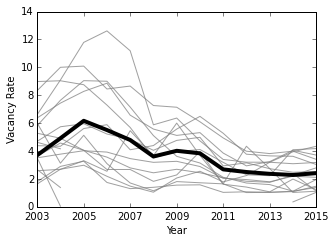

In [413]:
fig, axis = plt.subplots(1, figsize=(5, 3.5))

mask = np.ones_like(dataset_full[:, :, :, 0])*np.nan
mask[np.where(dataset_full[:, :, :, 0] > 10)] = 1

axis.plot(map(partial(datetime.datetime, month=1, day=1), year_axis),
         np.nanmean(dataset_full[:, :, :, 2]*mask, axis=1), color='gray', alpha=0.75)
axis.plot(map(partial(datetime.datetime, month=1, day=1), year_axis),
         np.nanmean(np.nanmean(dataset_full[:, :, :, 2]*mask, axis=1), axis=1),
          color='black', linewidth=4)

print np.nanmean(dataset_full[:, :, :, 2]*mask, axis=2).ravel()

axis.set_xlabel('Year')
axis.set_ylabel('Vacancy Rate')


In [444]:
mask = np.ones_like(dataset_full[:, :, :, 0])*np.nan
mask[np.where(dataset_full[:, :, :, 0] > 10)] = 1

vacs = np.nanmean(dataset_full[:, :, :, 2]*mask, axis=2).ravel()

year = 2002
with file('Vacancy_Rates_avg.csv', 'w') as f:
    f.write('Date,Quarter,Rate\n')
    for i, vac in enumerate(vacs):
        if not i%4:
            year += 1
        f.write("%d/%02d,%d,%3.4f\n" % (year, (i%4)*3+1, (i%4)+1, vac))





In [442]:
nzips = len(zip_dict.keys())
nyears = len(vacancy_data.keys())
nquarters = 4
ndims = 3
zip_axis = [k for k in zip_dict.keys()]
zip_order = {k: i for i, k in enumerate(zip_dict.keys())}

year_axis = [k for k in vacancy_data.keys()]
quarter_axis = range(1, 5)

with file('Vacancy_Rates.csv', 'w') as f:
    f.write('Date,%s\n' % ",".join(zip_dict.keys()))
    
    for i, (year, yearly_data) in enumerate(vacancy_data.iteritems()):
        for j, (quarter, quarterly_data) in enumerate(yearly_data.iteritems()):
            line = ["-1"]*(1+nzips)
            line[0] = "{:d}/{:02d}".format(year, quarter*4)
            for zip_data in quarterly_data:

                k = zip_order[zip_data[1]]+1

                if float(zip_data[2].replace(",", "")) > 20:                
                    try:
                        line[k] = zip_data[4].replace("\n", "")

                    except ValueError:
                        line[k] = str(float(zip_data[-2])/float(zip_data[-3]))
                        
            f.write("%s\n" % ",".join(line))

In [401]:
query_string = """
ogr2ogr -f GeoJSON -where "NAME = '%s'" zipcode.json WI_zipcode_regions.geojson
"""
query_string = query_string % "' OR NAME = '".join(zip_dict.keys())
print query_string


ogr2ogr -f GeoJSON -where "NAME = '54645' OR NAME = '53597' OR NAME = '53582' OR NAME = '53704' OR NAME = '53705' OR NAME = '53703' OR NAME = '54648' OR NAME = '53527' OR NAME = '54670' OR NAME = '53508' OR NAME = '53562' OR NAME = '53560' OR NAME = '53507' OR NAME = '53528' OR NAME = '53529' OR NAME = '53911' OR NAME = '53955' OR NAME = '53593' OR NAME = '54631' OR NAME = '54665' OR NAME = '53503' OR NAME = '54638' OR NAME = '54655' OR NAME = '53555' OR NAME = '53590' OR NAME = '53719' OR NAME = '53718' OR NAME = '54652' OR NAME = '53715' OR NAME = '53714' OR NAME = '53717' OR NAME = '53716' OR NAME = '53711' OR NAME = '53713' OR NAME = '53558' OR NAME = '53578' OR NAME = '53517' OR NAME = '53515' OR NAME = '53532' OR NAME = '53571' OR NAME = '53572' OR NAME = '53575' OR NAME = '53826' OR NAME = '53821' OR NAME = '53726' OR NAME = '53929' OR NAME = '54626' OR NAME = '53583' OR NAME = '53598'" zipcode.json WI_zipcode_regions.geojson



In [404]:
zip_dict

defaultdict(list,
            {u'53503': [{datetime.datetime(2003, 3, 1, 0, 0): u' 2.08'},
              {datetime.datetime(2003, 6, 1, 0, 0): u'\n6.25'},
              {datetime.datetime(2003, 9, 1, 0, 0): u'\n2.04'}],
             u'53507': [{datetime.datetime(2003, 3, 1, 0, 0): u' 25.00'},
              {datetime.datetime(2003, 6, 1, 0, 0): u'\n0.00'},
              {datetime.datetime(2003, 9, 1, 0, 0): u'\n0.00'}],
             u'53508': [{datetime.datetime(2003, 3, 1, 0, 0): u' 0.00'},
              {datetime.datetime(2003, 6, 1, 0, 0): u'\n0.00'},
              {datetime.datetime(2003, 9, 1, 0, 0): u'\n0.00'}],
             u'53515': [{datetime.datetime(2003, 3, 1, 0, 0): u' 3.03'},
              {datetime.datetime(2003, 6, 1, 0, 0): u'\n3.03'},
              {datetime.datetime(2003, 9, 1, 0, 0): u'\n2.85'},
              {datetime.datetime(2003, 12, 1, 0, 0): u'\n0.00'},
              {datetime.datetime(2004, 3, 1, 0, 0): u'\n0.00'}],
             u'53517': [{datetime.datetime(2